# AIMS CDT Signal Processing Lab Session 3 - Graph Neural Networks <br>
## Introduction



In this session, we will be looking into graph neural networks, a fast-growing field that generalises neural network architectures to deal with graph-structured data. We will be using PyTorch Geometric (PyG), a Python package for graph neural network operations. In addition, we will be using NetworkX for processing and visualising network data.

PyTorch Geometric: https://pytorch-geometric.readthedocs.io/en/latest/ <br>
NetworkX: https://networkx.org



Disclaimer: This lab session is partially inspired by [this online tutorial](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX).



The cell below will install PyTorch Geometric using CUDA 11.1. If you're using Colab you can use a GPU backend by navigating to `Runtime > Change runtime type`, and choosing GPU under Hardware accelerator. If you're running the notebook locally you can use the [PyG installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html) to generate an appropriate pip install command for your hardware. 

In [ ]:
# Install required packages.
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.1+cu113.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html


In [ ]:
# Import required packages.
import numpy as np
import pandas as pd
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric
from torch.nn import Linear
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv
from tqdm import tqdm
from copy import deepcopy
from sklearn.manifold import TSNE

plt.rcParams['image.cmap'] = 'Set2' # choose matplotlib colormap

We will be working with the Cora citation dataset made popular by the work on graph convolutional networks of [Kipf and Welling (2017)](https://arxiv.org/abs/1609.02907). The nodes in the Cora dataset represents papers, and edges represent citation links between them. For simplicity, we treat the network as undirected (there is a link between paper A and B if either A cites B or vice versa). In addition, each node comes with a set of attributes (bag-of-words features extracted from the corresponding paper) and a label (the field where the paper was published).


First of all, let us load the Cora dataset and compute some statistics assocaited with the network:

In [ ]:
dataset = Planetoid(root='data/', name='cora', pre_transform=ToUndirected())

Processing...
Done!


**Note: How PyTorch represents the data**

The `dataset.data` variable contains information about the Cora citation graph, the node features and the node labels. Nodes are indexed $0, \ldots, n-1$. Edges are given by the $2 \times |E|$ tensor `dataset.data.edge_index` where each column contains two numbers $u$ and $v$ representing a directed edge `u → v`. In PyTorch Geometric all graphs are directed. We can represent an undirected graph by representing each undirected edge `u ~ v` with two directed edges `u → v` and  `v → u`. Because we are treating Cora as an undirected graph, we divide `dataset.data.num_edges` by 2 to count the number of (undirected) edges. The node features are stored in the $n \times d$ matrix `dataset.data.x` with the $i$th row being the feature vector for node $i$. Finally node labels are given by the vector `dataset.data.y` where the $i$th entry is the label for node $i$.

In [ ]:
print('Number of nodes:', dataset.data.num_nodes)
print('Number of edges:', dataset.data.num_edges // 2) 
print('Feature dimension:', dataset.data.x.size(1))

Number of nodes: 2708
Number of edges: 5278
Feature dimension: 1433


Let us also look at node label statistics. Recall that the nodes represent a research paper. The corresponding label is the research subfield.  

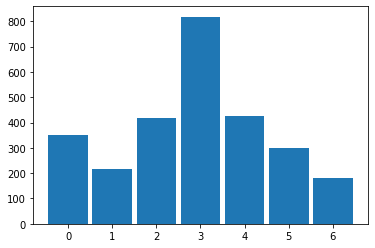

In [ ]:
#Distribution of node labels?
fig, ax = plt.subplots()
labels = dataset.data.y
ax.hist(labels, bins=np.arange(8)-0.5, rwidth=0.9)
print()

Recall that the nodes represent a research paper. The corresponding label is the research subfield. The dictionary below gives the subfield associated to each label.



In [ ]:
label_map = {0: 'Theory',
             1: 'Reinforcement Learning',
             2: 'Genetic Algorithms',
             3: 'Neural Networks',
             4: 'Probabilistic Methods',
             5: 'Case Based',
             6: 'Rule Learning'}

The graph is too large to visualise effectively so let us instead visualise a subset of the data.

In [ ]:
def plot_subset(data, ax, pos, seed=0):
    graph_nx = to_networkx(data, node_attrs=['y'], to_undirected=True)
    subgraph_nx = graph_nx.subgraph(pos.keys())

    # plot graph
    nodelist = list(subgraph_nx.nodes())
    node_size = [10*(subgraph_nx.degree(node)+1) for node in nodelist]
    color = [graph_nx.nodes(data=True)[node]['y'] for node in nodelist]
    nx.draw_networkx_nodes(subgraph_nx, pos = pos, nodelist=nodelist, node_size=node_size, node_color=color, ax=ax)
    nx.draw_networkx_edges(subgraph_nx, pos = pos, nodelist=nodelist, alpha=0.2, ax=ax)
    ax.axis("off")

def subgraph_layout(data, seed=0):
    """Defines coordinates for a subsgraph of data."""

    # set seed
    np.random.seed(seed)

    # change to networkx and select largest connected component
    data = deepcopy(data)
    graph_nx = to_networkx(data, node_attrs=['y'], to_undirected=True)
    subgraph_nx = graph_nx.subgraph(max(nx.connected_components(graph_nx), key=len))

    # select a subgraph
    random_node = np.random.choice(subgraph_nx.nodes())
    subgraph_nx = nx.ego_graph(subgraph_nx, random_node, radius=3)

    # calculate pos
    pos = nx.spring_layout(subgraph_nx)
    return pos

In [ ]:
[i for i in plt.get_cmap().colors]

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

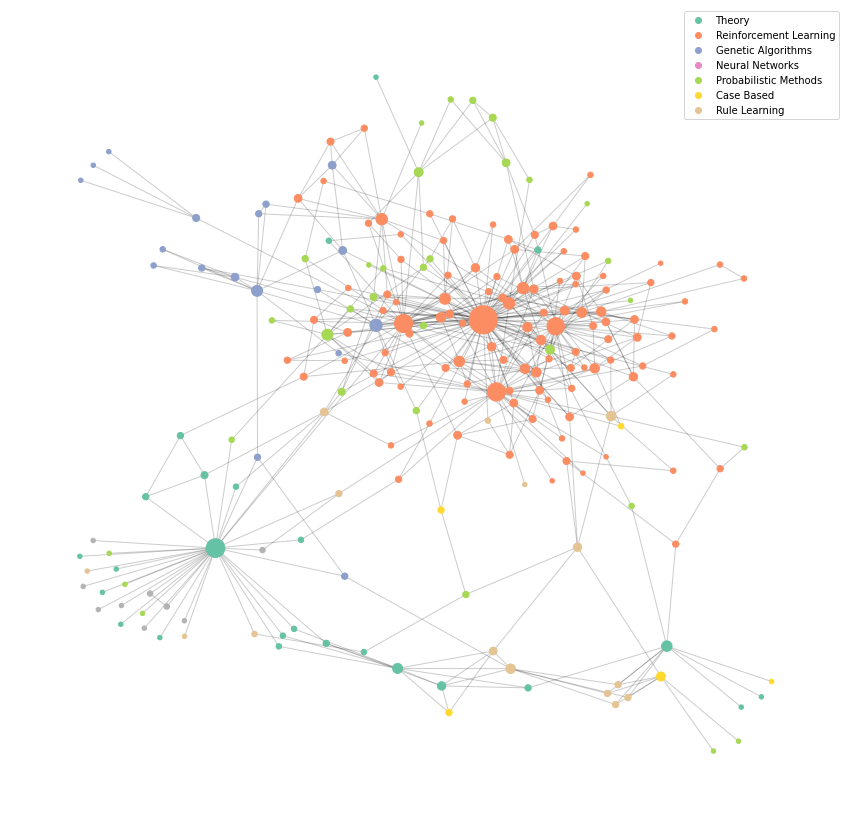

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
pos = subgraph_layout(dataset.data, seed=0)
plot_subset(dataset.data, ax, pos)

colours = plt.get_cmap().colors
handles = [plt.Line2D([0,], [0,], marker='o', color=colour, lw=0) for colour in colours]
ax.legend(handles, [label_map[i] for i in range(len(label_map))])

* Can you observe the similarity in labels between nodes that are connected in the network?
* Can you think of a way of quantifying such similarity?

Implement the following definition of homophily as defined in [Zhu et al. (2020)](https://arxiv.org/abs/2006.11468):

 $$h = \frac{ | \{ \{u,v\} : \{u, v\} \in \mathcal{E} \text{ and } y_u = y_v\}|}{|\mathcal{E}|},$$

 and use this to calculate homophily of the Cora citation network.

*So this definition of homophily is basically how many edges connect nodes with the same label*

In [ ]:
def mean_tensor(t):
  return t.sum().div(len(t)).item()

def homophily(data):
    # TASK: implement this function
    assert type(data) is torch_geometric.data.data.Data
    assert type(data.edge_index) is torch.Tensor
    nodes_per_edge, num_edges = data.edge_index.shape
    assert nodes_per_edge == 2
    boolean_array = (
        data.y[data.edge_index[0, :]] ==
        data.y[data.edge_index[1, :]]
    )

    return mean_tensor(boolean_array)

print('Cora homophily:', homophily(dataset.data))

Cora homophily: 0.8099659085273743


We will be considering a semi-supervised node classification task, where we wish to label the nodes for which we do not have labels (fields where papers were published) given a set of nodes with known labels as well as the citation network.

* From the above observation, could you justify the use of graph neural networks for this task?

- *Yes, because >80% of edges connect nodes with the same label*
- *So given a node, if we look at all its neighbours, if most of the neighbours have a common label, then the given node probably has the same label*

**[Checkpoint 1]** You are now done with the first part of the exercises. Please ask a lab demonstrator to evaluate your work in this part.

## Implementing graph neural networks

We are now ready to use PyG to implement graph neural networks. We will first follow the simple graph convolutional network (GCN) model proposed by [kipf and Welling (2017)](https://arxiv.org/abs/1609.02907), which is covered in the lectures. We will consider a network that consists of 2 GCN convolutional layers each of which is enhanced by a non-linear activation function. After that, we apply a simple linear transformation which acts as a classifier.

In [ ]:
## Class defining the Graph Convolutional layer
class GCN(torch.nn.Module):

    def __init__(self, dropout=0.0):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 50) # The first layer map the node features to a 30-dimensional vector.
        self.conv2 = GCNConv(50, 10) # The second layer output a 10-dimensional vector.
        # self.conv2 = GCNConv(50, 50) # The second layer output a 10-dimensional vector.
        # self.conv3 = GCNConv(50, 10) # The second layer output a 10-dimensional vector.
        self.classifier = Linear(10, dataset.num_classes) # The last layer is linear and output class scores.
        self.dropout = dropout

    def forward(self, x, edge_index):
        # After each convolutional layer we apply a relu non linear transformation and dropout (optional).
        h = self.conv1(x, edge_index)
        h = h.relu() 
        h = torch.nn.functional.dropout(h, p=self.dropout)

        h = self.conv2(h, edge_index)
        h = h.relu() # node embeddings
        h = torch.nn.functional.dropout(h, p=self.dropout)

        # h = self.conv3(h, edge_index)
        # h = h.relu() # node embeddings
        # h = torch.nn.functional.dropout(h, p=self.dropout)
         
        # Apply a final (linear) classifier.
        out = self.classifier(h)
        return out, h

model = GCN()
print("Model architecture:")
print(model)
gcn_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {gcn_total_params}")

Model architecture:
GCN(
  (conv1): GCNConv(1433, 50)
  (conv2): GCNConv(50, 10)
  (classifier): Linear(in_features=10, out_features=7, bias=True)
)
Number of parameters: 72287


In [ ]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)  # Define optimizer.

def train(data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.
    
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, train_acc, h
  
def validation(data):
    model.eval()
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    valid_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    valid_acc = int(valid_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    loss_valid = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the training nodes.
    return loss_valid, valid_acc, h

d = {"Training_Loss": [], 'Training_Acc': [], "Validation_Loss": [], "Validation_Acc": [], "epoch" : []}
for epoch in range(100):
    loss, train_acc, h = train(dataset.data)
    valid_loss, valid_acc, h = validation(dataset.data)
    d["Training_Loss"].append(loss)
    d["Training_Acc"].append(train_acc)
    d["Validation_Loss"].append(valid_loss)
    d["Validation_Acc"].append(valid_acc)
    d["epoch"].append(epoch)
    if epoch % 10 == 0:
      print(f"Epoch {epoch}: Training Accuracy {train_acc}, Validation Accuracy {valid_acc}")

model.eval()
_, h_post = model(dataset.data.x, dataset.data.edge_index)

Epoch 0: Training Accuracy 0.1357142857142857, Validation Accuracy 0.078
Epoch 10: Training Accuracy 0.8642857142857143, Validation Accuracy 0.62
Epoch 20: Training Accuracy 0.9928571428571429, Validation Accuracy 0.766
Epoch 30: Training Accuracy 1.0, Validation Accuracy 0.762
Epoch 40: Training Accuracy 1.0, Validation Accuracy 0.768
Epoch 50: Training Accuracy 1.0, Validation Accuracy 0.768
Epoch 60: Training Accuracy 1.0, Validation Accuracy 0.768
Epoch 70: Training Accuracy 1.0, Validation Accuracy 0.774
Epoch 80: Training Accuracy 1.0, Validation Accuracy 0.77
Epoch 90: Training Accuracy 1.0, Validation Accuracy 0.768


In [ ]:
# Define this function to avoid errors when plotting d["Training_Loss"] and ["Validation_Loss"]
def extract_items(t_list):
  return [x.item() for x in t_list]

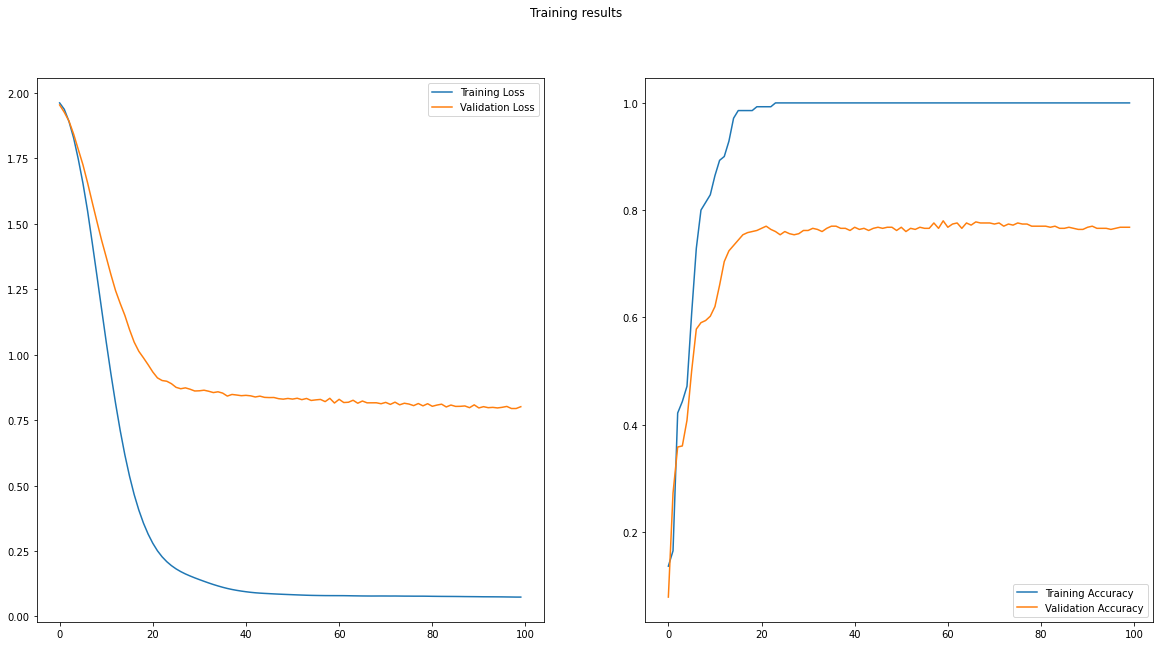

In [ ]:
### Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Training results')
ax1.plot(d["epoch"], extract_items(d["Training_Loss"]), label='Training Loss')
ax1.plot(d["epoch"], extract_items(d["Validation_Loss"]), label='Validation Loss')
ax1.legend()


ax2.plot(d["epoch"], d["Training_Acc"], label='Training Accuracy')
ax2.plot(d["epoch"], d["Validation_Acc"], label='Validation Accuracy')
ax2.legend();

Tips on GNN training:
- Graph neural network models are known to suffer from a feature oversmoothing phenomenon on node representation (https://arxiv.org/abs/1801.07606). As a result, stacking too many layers in GNN does not result in better performance contrary to classical deep learning architecture. When applying GNNs in the real world, a few layers (2 or 3) often results in the best performances.
- Play around with the hidden feature dimensions.
- Control overfitting with weight decay (L2 regularization) and dropout.

Let's compare the node representations before and after applying the GNNs. Here we show the t-SNE visualisation of the initial node representation (input features) and the representations learned by the GNN:

* Can you comment on the two visualisations and what the GNN has obtained?
* What about if we make minor changes to the architecture, e.g., increase the number of GCN layers?

In [ ]:
def visualise_tsne(features, labels, ax):
    z = TSNE(n_components=2).fit_transform(features.detach().cpu().numpy())
    ax.scatter(z[:, 0], z[:, 1], s=70, c=labels)
    ax.axis("off")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


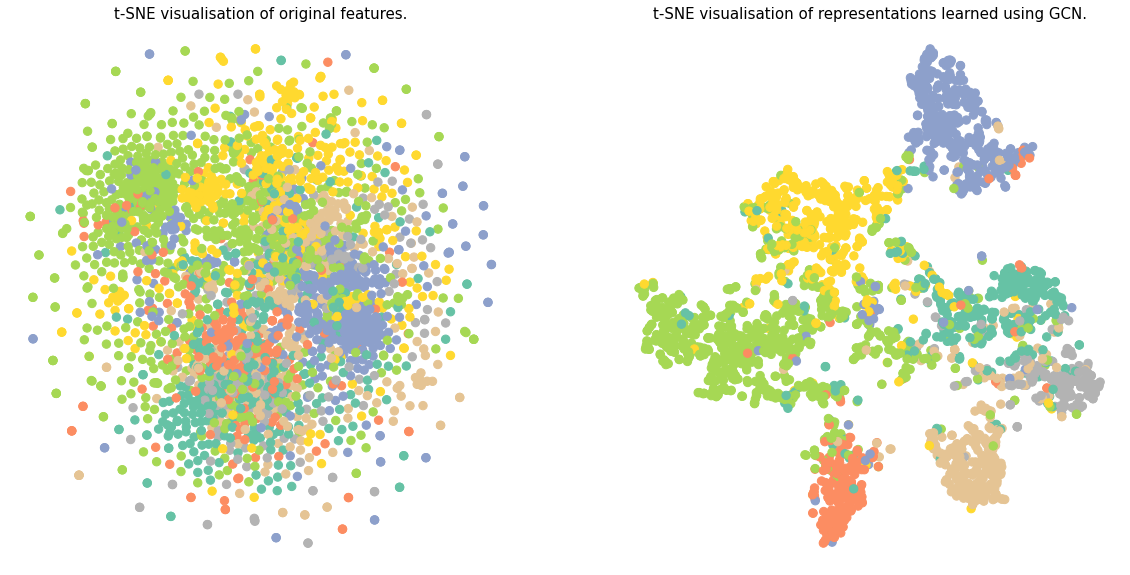

In [ ]:
# note this may take a minute or two to run

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].set_title('t-SNE visualisation of original features.', fontsize=15)
axs[1].set_title('t-SNE visualisation of representations learned using GCN.', fontsize=15)
axs[0].axis('off'); axs[1].axis('off')
visualise_tsne(dataset.data.x, dataset.data.y, axs[0])
visualise_tsne(h_post, dataset.data.y, axs[1])

Let's compare the performance of GNN-based approach with two simple baselines: <br>
1) A multi-layer perception (MLP) network, which makes use of the input node features but not the graph topology; <br>
2) A simple label propogation approach proposed in [Zhou and Schölkopf (2004)](https://www.microsoft.com/en-us/research/publication/regularization-framework-learning-graph-data/), which uses the graph topology but not the input node features.

Let's first implement the MLP.

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.lin1 = Linear(dataset.num_features, 40)
        self.lin2 = Linear(40, 10)
        self.classifier = Linear(10, dataset.num_classes)

    def forward(self, x):
        h = self.lin1(x)
        h = h.relu()
        h = self.lin2(h)
        h = h.relu()
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model_MLP = MLP()
pytorch_total_params = sum(p.numel() for p in model_MLP.parameters() if p.requires_grad)
print(pytorch_total_params)

57847


In [ ]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=0.01)  # Define optimizer.

model_MLP.eval()
_, h_initial = model_MLP(dataset.data.x) #Initial Latent Representation

def train_MLP(data):
    model_MLP.train()
    optimizer.zero_grad()  # Clear gradients.
    out, h = model_MLP(data.x)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.
    
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, train_acc, h
  
def validation_MLP(data):
    model_MLP.eval()
    out, h = model_MLP(data.x)  # Perform a single forward pass.
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    valid_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    valid_acc = int(valid_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    loss_valid = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the training nodes.
    return loss_valid, valid_acc, h

d = {}
d["Training_Loss"], d["Training_Acc"], d["Validation_Loss"], d["Validation_Acc"], d["epoch"] = [], [], [], [], []
for epoch in range(200):
    loss, train_acc, h = train_MLP(dataset.data)
    validation_loss, validation_acc, h = validation_MLP(dataset.data)
    d["Training_Loss"].append(loss)
    d["Training_Acc"].append(train_acc)
    d["Validation_Loss"].append(validation_loss)
    d["Validation_Acc"].append(validation_acc)
    d["epoch"].append(epoch)
    if epoch % 10 == 0:
      print(f"Epoch {epoch}: Training Accuracy {train_acc}, Validation Accuracy {validation_acc}")

model_MLP.eval()
_, h_post = model_MLP(dataset.data.x)

Epoch 0: Training Accuracy 0.14285714285714285, Validation Accuracy 0.162
Epoch 10: Training Accuracy 0.6428571428571429, Validation Accuracy 0.242
Epoch 20: Training Accuracy 1.0, Validation Accuracy 0.316
Epoch 30: Training Accuracy 1.0, Validation Accuracy 0.402
Epoch 40: Training Accuracy 1.0, Validation Accuracy 0.39
Epoch 50: Training Accuracy 1.0, Validation Accuracy 0.382
Epoch 60: Training Accuracy 1.0, Validation Accuracy 0.386
Epoch 70: Training Accuracy 1.0, Validation Accuracy 0.39
Epoch 80: Training Accuracy 1.0, Validation Accuracy 0.396
Epoch 90: Training Accuracy 1.0, Validation Accuracy 0.394
Epoch 100: Training Accuracy 1.0, Validation Accuracy 0.394
Epoch 110: Training Accuracy 1.0, Validation Accuracy 0.396
Epoch 120: Training Accuracy 1.0, Validation Accuracy 0.396
Epoch 130: Training Accuracy 1.0, Validation Accuracy 0.396
Epoch 140: Training Accuracy 1.0, Validation Accuracy 0.398
Epoch 150: Training Accuracy 1.0, Validation Accuracy 0.398
Epoch 160: Training Ac

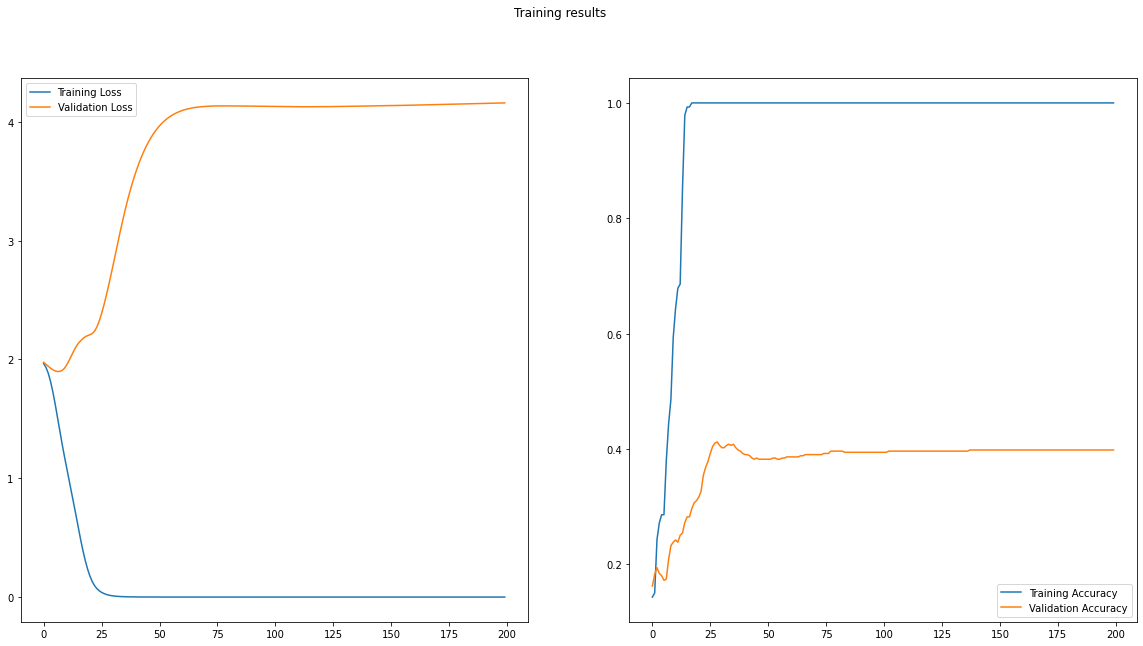

In [ ]:
### Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Training results')
ax1.plot(d["epoch"], extract_items(d["Training_Loss"]), label='Training Loss')
ax1.plot(d["epoch"], extract_items(d["Validation_Loss"]), label='Validation Loss')
ax1.legend()


ax2.plot(d["epoch"], d["Training_Acc"], label='Training Accuracy')
ax2.plot(d["epoch"], d["Validation_Acc"], label='Validation Accuracy')
ax2.legend();

Visualise the representations learned by the MLP.

* Can you compare this with the visualisation of the representations learned by the GNN above?

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


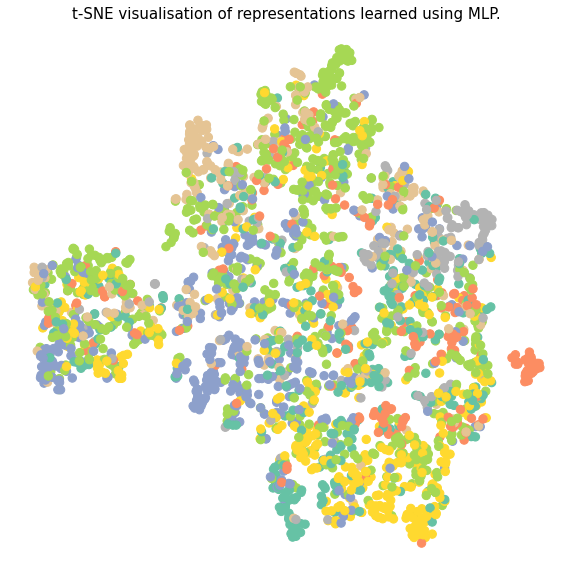

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
visualise_tsne(h_post, dataset.data.y, ax)
ax.set_title('t-SNE visualisation of representations learned using MLP.', fontsize=15)
ax.axis('off');

The label propagation approach in [Zhou and Schölkopf (2004)](https://www.microsoft.com/en-us/research/publication/regularization-framework-learning-graph-data/) simply learns labels by minimising the Dirichlet energy. A simple implementation of label propagation is provided below:

In [ ]:
def label_prop(dataset):
    G = to_networkx(dataset.data, node_attrs=['y'], to_undirected=True)
    train_id = dataset.data.train_mask
    labels = np.array(list(nx.get_node_attributes(G, 'y').values())).reshape(-1,1)
    # convert to one hot encode
    labels_one_hot = np.zeros((G.number_of_nodes(), labels.max()+1))
    for i in range(labels.max()+1):
        # if equal to label set 1, not equal to label set -1, unlabeled set to 0
        labels_one_hot[:np.sum(train_id.numpy()), i] = -1
        labels_one_hot[:np.sum(train_id.numpy()), i][(labels[train_id] == i).flatten()] = 1
        
    D = np.diag(np.array(nx.adjacency_matrix(G).todense()).sum(axis = 0)) # degree matrix
    A = nx.adjacency_matrix(G).todense() # weight matrix
    T = np.linalg.inv(D) @ A # lazy random walk

    alpha = 0.9 # from paper
    inv = np.linalg.inv(np.eye(T.shape[0]) - alpha*T)
    prob = inv @ labels_one_hot
    pred = prob.argmax(1) # find max in the column
    # return percentage accuracy on test
    return np.sum(pred[dataset.data.val_mask] == labels[dataset.data.val_mask])/np.sum(dataset.data.val_mask.numpy()) * 100

In [ ]:
label_prop_acc = label_prop(dataset)
print(f'label propagation accuracy = {label_prop_acc:.2f}%')

label propagation accuracy = 69.00%


* What is the main difference between the three approaches (GNN, MLP, LP)?
* Can you comment on the advantage of a GNN-based approach?

**[Checkpoint 2]** You are now done with the second part of the exercises. Please ask a lab demonstrator to evaluate your work in this part.

## Analysing GNNs under topological perturbation

As you can imagine, the input graph topology plays an important role in the GNNs.

* What about if the input graph is noisy (e.g., due to inaccuracy in its construction) or perturbed (e.g., due to adversaries)?
* What types of topological perturbations can you think of?

In this exercise, we will be looking into the following perturbation strategies: <br>


1.   Random perturbation of edges (random);
2.   A more strategic perturbation (DICE) from [Waniek et al. (2018)](https://www.nature.com/articles/s41562-017-0290-3).

The random strategy adds non-existent edges and removes present edges uniformly at random. The DICE strategy also samples edges, but will only sample edges to add if the endpoints have different labels and will only sample edges to remove if they have the same label. We provide code for both below.

In [ ]:
def perturb_random(data, add, remove):
    """
    Add and remove edges uniformly at random.

    parameters:
        data: torch_geometric.data.data.Data input graph
        add: number of edges to add 
        remove: number of edges to remove

    returns:
        a copy of the data with a perturbed graph
    """
    # so original data is not modified
    data = deepcopy(data)

    # networkx graph for convenient sampling
    graph_nx = to_networkx(data, to_undirected=True)

    # sample edges to remove
    edges = list(graph_nx.edges)
    edges_to_remove = [edges[i] for i in np.random.choice(range(len(edges)), remove, replace=False)]

    # sample edges to add
    edges_to_add = []
    while len(edges_to_add) < add:
        edge = list(np.random.choice(list(graph_nx.nodes()), 2, replace=False))
        edge = (min(edge), max(edge))
        if edge not in graph_nx.edges and edge not in edges_to_add:
            edges_to_add.append(edge)

    # now modify PyG edge index (graph topology)
    edge_index = data.edge_index

    # calculate row indices to delete (both directions)
    mask_idx = [] 
    for edge in edges_to_remove:
        mask_idx.append(torch.where((torch.tensor(edge) == edge_index.T).all(axis=1))[0].item())
        mask_idx.append(torch.where((torch.tensor(edge[::-1]) == edge_index.T).all(axis=1))[0].item())

    # delete rows using a mask
    mask = torch.ones(edge_index.T.size(0))
    mask[mask_idx] = 0
    edge_index = edge_index.T[mask.bool()].T

    # add edges
    edges_to_add = torch.tensor(edges_to_add)
    edges_to_add = torch.cat([edges_to_add, edges_to_add[:, [1, 0]]])
    edge_index = torch.cat((edge_index.T, edges_to_add)).T

    # assign new edges and return
    data.edge_index = edge_index
    return data

In [ ]:
def perturb_dice(data, add, remove):
    """
    Add and remove edges using DICE (disconnect internally, connect externally)

    parameters:
        data: torch_geometric.data.data.Data input graph
        add: number of edges to add 
        remove: number of edges to remove

    returns:
        a copy of the data with a perturbed graph
    """
    # so original data is not modified
    data = deepcopy(data)

    # networkx graph for convenient sampling
    graph_nx = to_networkx(data, to_undirected=True)

    # sample edges to remove
    edges = list(graph_nx.edges)
    edges_idx = [i for i, edge in enumerate(edges) if (data.y[edge[0]] == data.y[edge[1]]).item()]
    edges_to_remove = [edges[i] for i in np.random.choice(edges_idx, remove, replace=False)]

    # sample edges to add
    edges_to_add = []
    while len(edges_to_add) < add:
        edge = list(np.random.choice(list(graph_nx.nodes()), 2, replace=False))
        edge = (min(edge), max(edge))
        different_label = (data.y[edge[0]] != data.y[edge[1]]).item()
        if edge not in graph_nx.edges and edge not in edges_to_add and different_label:
            edges_to_add.append(edge)

    # now modify PyG edge index (graph topology)
    edge_index = data.edge_index

    # calculate row indices to delete (both directions)
    mask_idx = [] 
    for edge in edges_to_remove:
        mask_idx.append(torch.where((torch.tensor(edge) == edge_index.T).all(axis=1))[0].item())
        mask_idx.append(torch.where((torch.tensor(edge[::-1]) == edge_index.T).all(axis=1))[0].item())

    # delete rows using a mask
    mask = torch.ones(edge_index.T.size(0))
    mask[mask_idx] = 0
    edge_index = edge_index.T[mask.bool()].T

    # add edges
    edges_to_add = torch.tensor(edges_to_add)
    edges_to_add = torch.cat([edges_to_add, edges_to_add[:, [1, 0]]])
    edge_index = torch.cat((edge_index.T, edges_to_add)).T

    # assign new edges and return
    data.edge_index = edge_index
    return data


Let's visualise the perturbed graph data using the subset of the Cora data above:

* Similar to above, can you compute the homophily level of node labels again? 
* What do you observe compared to the case of clean graph? What consequence does this have on the GNN?


In [ ]:
# perturb the graph using a budget of 0.5*|E| for add and remove (i.e. delete half the edges and add the same number back).
number_of_edges = int(dataset.data.num_edges / 2)
add = int(0.5 * number_of_edges)
remove = int(0.5 * number_of_edges)
data_random = perturb_random(dataset.data, add, remove)
data_dice = perturb_dice(dataset.data, add, remove)

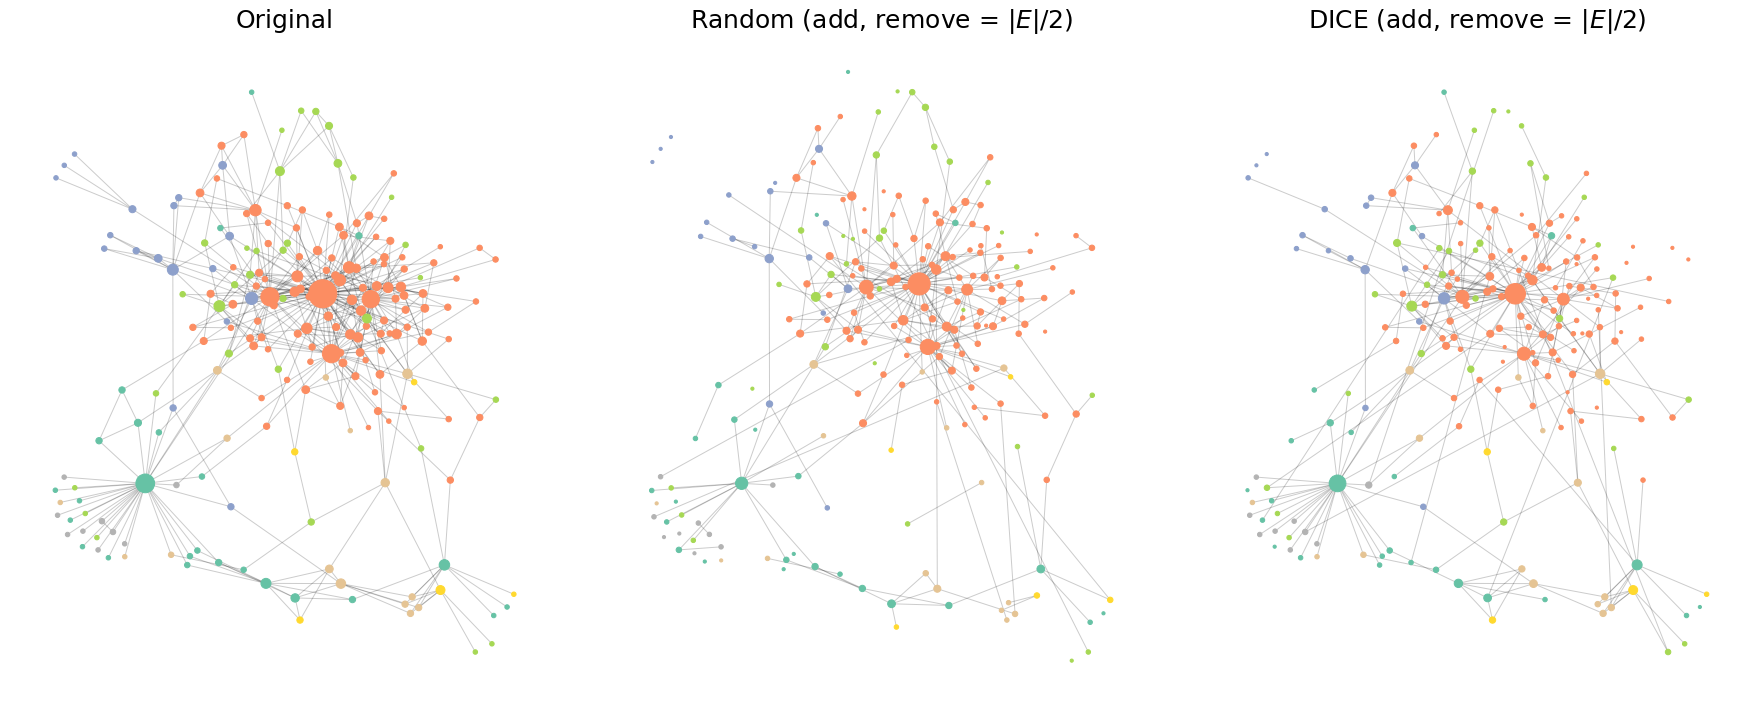

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(25, 10))
fig.tight_layout()
plot_subset(dataset.data, axs[0], pos=pos)
plot_subset(data_random, axs[1], pos=pos)
plot_subset(data_dice, axs[2], pos=pos)
axs[0].set_title('Original', fontsize=25); 
axs[1].set_title(r'Random (add, remove = $|E|/2$)', fontsize=25)
axs[2].set_title(r'DICE (add, remove = $|E|/2$)', fontsize=25);

In [ ]:
print("homophily(dataset.data) = %f" % homophily(dataset.data))
print("homophily(data_random) = %f" % homophily(data_random))
print("homophily(data_dice) = %f" % homophily(data_dice))

homophily(dataset.data) = 0.809966
homophily(data_random) = 0.494316
homophily(data_dice) = 0.309966


We will focus on the scenario where the input graph is clean during the training of the GNN model, but perturbed during inference (this corresponds to an *evasion* attack setting in the adversarial learning literature). Let's implement this using the perturbation strategies described above and compare the performance:

1) train a GCN model using the original clean graph;<br/>
2) perturb the clean graph using random perturbation or DICE, while keeping the node features unchanged;<br/>
3) apply the trained GCN model to perturbed graph data to predict labels of testing nodes;<br/>
4) repeat step 2) with a different amount of perturbation.

* Can you observe the relationship between performance drop and amount of perturbation?
* From this exercise, what can we say about the robustness of GNNs against topological perturbation, in the context of semi-supervised node classification? Hint: does the robustness depend on the homophily level of the node labels and, if yes, why?

In [ ]:
for data in [dataset.data, data_random, data_dice]:
  valid_loss, valid_acc, h = validation(data)
  print(valid_acc)

0.768
0.604
0.494


p = 0.800000

Text(0, 0.5, 'Validation accuracy')

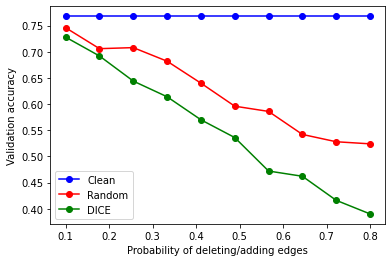

In [ ]:
p_list = np.linspace(0.1, 0.8, 10)
clean_acc_list = []
random_acc_list = []
dice_acc_list = []
for p in p_list:
  print("\rp = %f" % p, end="", flush=True)
  number_of_edges = int(dataset.data.num_edges / 2)
  add = int(p * number_of_edges)
  remove = int(p * number_of_edges)
  data_random = perturb_random(dataset.data, add, remove)
  data_dice = perturb_dice(dataset.data, add, remove)
  clean_acc_list.append(validation(dataset.data)[1])
  random_acc_list.append(validation(data_random)[1])
  dice_acc_list.append(validation(data_dice)[1])

plt.plot(p_list, clean_acc_list, "bo-", label="Clean")
plt.plot(p_list, random_acc_list, "ro-", label="Random")
plt.plot(p_list, dice_acc_list, "go-", label="DICE")
plt.legend()
plt.xlabel("Probability of deleting/adding edges")
plt.ylabel("Validation accuracy")

**[Checkpoint 3]** You are now done with the third part of the exercises. Please ask a lab demonstrator to evaluate your work in this part.

**[Optional]** As an optional extension, read into a more advanced graph neural network architecture, the graph attention networks (GAT) from [Veličković et al. (2018)](https://arxiv.org/abs/1710.10903). Can you use PyTorch Geometric to implement the GAT and see how it performs compared to the GCN?

Blogpost : https://petar-v.com/GAT/

Tutorial for GAT : https://github.com/gordicaleksa/pytorch-GAT